## Look before you leap: EDA before hypothesis testing
Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data. They are stored in a Pandas data frame, df, where column ID is the identity of the frog and column impact_force is the impact force in Newtons (N)

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
sns.set_style('darkgrid')
#init
path = "K:\\TensorflowPY36CPU\\TensorflowPY36CPU\\_14_Plot\\"
df= pd.read_csv(path+'frog.csv',index_col=[0])
df.head()

,ID,impact_force
20,A,1.612
21,A,0.605
22,A,0.327
23,A,0.946
24,A,0.541


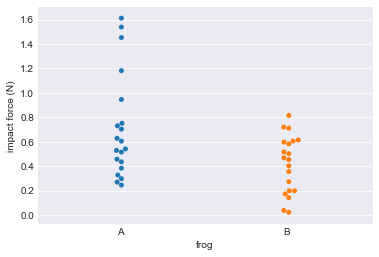

In [8]:
# Make bee swarm plot
_ = sns.swarmplot(x='ID',y='impact_force',data=df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


### A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.

####Eyeballing it, it does not look like they come from the same distribution. Frog A, the adult, has three or four very hard strikes, and Frog B, the juvenile, has a couple weak ones. However, it is possible that with only 20 samples it might be too difficult to tell if they have difference distributions, so we should proceed with the hypothesis test.

#### Permutation test on frog data
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. You will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

For your convenience, the data has been stored in the arrays force_a and force_b.

In [9]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


In [10]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


In [11]:
force1= df[df['ID']=='A ']
force_a = force1.impact_force.values
force_b =df[df['ID']=='B '].impact_force.values


In [12]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff =np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a,force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.003


#### The p-value tells you that there is about a 0.6% chance that you would get the difference of means observed in the experiment if frogs were exactly the same. A p-value below 0.01 is typically said to be "statistically significant,", but: warning! warning! warning! You have computed a p-value; it is a number. I encourage you not to distill it to a yes-or-no phrase. p = 0.006 and p = 0.000000006 are both said to be "statistically significant," but they are definitely not the same!

## Pipeline for hypothesis testing
 - Clearly stat the null  hyppthesis
 - Define my test statistic
 - Generate manay sets of simulated data assuming the null hypothesis is true
 - Compute the test statistic for the each stimulated data set
 - The p-value is the fraction of your stimulated data sets for which the test statistics at least as extreme as for the real data

## Null hypothesis
 - THe true mean speed of light in Michelson's experiement was actually Newcomb's reported values


### A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [13]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D Data"""
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates
#def draw_bs_reps(data, func, size=1):
#    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])


In [14]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


In [15]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b)+0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)


p =  0.0061


#### Great work! The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false

### A bootstrap test for identical distribution
In the video, we looked at a one-sample test, but we can do two sample tests. We can even test the same hypothesis that we tested with a permutation test: that the Frog A and Frog B have identically distributed impact forces. To do this test on two arrays with n1 and n2 entries, we do a very similar procedure as a permutation test. We concatenate the arrays, generate a bootstrap sample from it, and take the first n1 entries of the bootstrap sample as belonging to the first data set and the last n2 as belonging to the second. We then compute the test statistic, e.g., the difference of means, to get a bootstrap replicate. The p-value is the number of bootstrap replicates for which the test statistic is less than what was observed.

Now, you will perform a bootstrap test of the hypothesis that Frog A and Frog B have identical distributions of impact forces using the difference of means test statistic.

The two arrays are available to you as force_a and force_b.

In [16]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a,force_b)

# Concatenate forces: forces_concat
forces_concat = np.concatenate((force_a,force_b))

# Initialize bootstrap replicates: bs_replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(forces_concat, size=len(forces_concat))
    
    # Compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(force_a)],
                                     bs_sample[len(force_b):])

# Compute and print p-value: p
p = np.sum(bs_replicates>=empirical_diff_means) / 10000
print('p-value =', p)


p-value = 0.0066


#### Great work! You may remember that we got p = 0.0063 from the permutation test, and here we got p = 0.0055. These are very close, and indeed the tests are testing the same thing. However, the permutation test exactly simulates the null hypothesis that the data come from the same distribution, whereas the bootstrap test approximately simulates it. As we will see, though, the bootstrap hypothesis test, while approximate, is more versatile.

###A two-sample bootstrap hypothesis test for difference of means.
You performed a one-sample bootstrap hypothesis test, which is impossible to do with permutation. Testing the hypothesis that two samples have the same distribution may be done with a bootstrap test, but a permutation test is preferred because it is more accurate (exact, in fact). But therein lies the limit of a permutation test; it is not very versatile. We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution. This, too, is impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

The objects forces_concat and empirical_diff_means are already in your namespace.

In [17]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)    
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / 10000
print('p-value =', p)


p-value = 0.0045


#### Nice work! Not surprisingly, the more forgiving hypothesis, only that the means are equal as opposed to having identical distributions, gives a higher p-value. Again, it is important to carefully think about what question you want to ask. Are you only interested in the mean impact force, or the distribution of impact forces?

You have finished the chapter "Introduction to hypothesis testing"!

Please give a rating:



### The vote for the Civil Rights Act in 1964
The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yay. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

To answer this question, you will evaluate the hypothesis that the party of a House member has no bearing on his or her vote. You will use the fraction of Democrats voting in favor as your test statistic and evaluate the probability of observing a fraction of Democrats voting in favor at least as small as the observed fraction of 153/244. (That's right, at least as small as. In 1964, it was the Democrats who were less progressive on civil rights issues.) To do this, permute the party labels of the House voters and then arbitrarily divide them into "Democrats" and "Republicans" and compute the fraction of Democrats voting yay.

In [18]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yay_dems(dems, reps):
    """Compute fraction of Democrat yay votes."""
    frac = np.sum(dems) / len(dems)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dems, reps, frac_yay_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)


p-value = 0.0001


#### Great work! This small p-value suggests that party identity had a lot to do with the voting. Importantly, the South had a higher fraction of Democrat representatives, and consequently also a more racist bias.


## A time-on-website analog

It turns out that you already did a hypothesis test analogous to an A/B test where you are interested in how much time is spent on the website before and after an ad campaign. The frog tongue force (a continuous quantity like time on the website) is an analog. "Before" = Frog A and "after" = Frog B. Let's practice this again with something that is actually a before/after scenario.

We return to the no-hitter data set. In 1920, Major League Baseball implemented important rule changes that ended the so-called dead ball era. Importantly, the pitcher was no longer allowed to spit on or scuff the ball, an activity that greatly favors pitchers. In this problem you will perform an A/B test to determine if these rule changes resulted in a slower rate of no-hitters (i.e., longer average time between no-hitters) using the difference in mean inter-no-hitter time as your test statistic. The inter-no-hitter times for the respective eras are stored in the arrays nht_dead and nht_live, where "nht" is meant to stand for "no-hitter time."

Since you will be using your draw_perm_reps() function in this exercise, it may be useful to remind yourself of its call signature: draw_perm_reps(d1, d2, func, size=1) or even referring back to the chapter 3 exercise in which you defined it.

In [19]:
#init
nht_dead= np.array([  -1,  894,   10,  130,    1,  934,   29,    6,  485,  254,  372,
         81,  191,  355,  180,  286,   47,  269,  361,  173,  246,  492,
        462, 1319,   58,  297,   31, 2970,  640,  237,  434,  570,   77,
        271,  563, 3365,   89,    0,  379,  221,  479,  367,  628,  843,
       1613, 1101,  215,  684,  814,  278,  324,  161,  219,  545,  715,
        966,  624,   29,  450,  107,   20,   91, 1325,  124, 1468,  104,
       1309,  429,   62, 1878, 1104,  123,  251,   93,  188,  983,  166,
         96,  702,   23,  524,   26,  299,   59,   39,   12,    2,  308,
       1114,  813,  887])
nht_live= np.array([ 645, 2088,   42, 2090,   11,  886, 1665, 1084, 2900, 2432,  750,
       4021, 1070, 1765, 1322,   26,  548, 1525,   77, 2181, 2752,  127,
       2147,  211,   41, 1575,  151,  479,  697,  557, 2267,  542,  392,
         73,  603,  233,  255,  528,  397, 1529, 1023, 1194,  462,  583,
         37,  943,  996,  480, 1497,  717,  224,  219, 1531,  498,   44,
        288,  267,  600,   52,  269, 1086,  386,  176, 2199,  216,   54,
        675, 1243,  463,  650,  171,  327,  110,  774,  509,    8,  197,
        136,   12, 1124,   64,  380,  811,  232,  192,  731,  715,  226,
        605,  539, 1491,  323,  240,  179,  702,  156,   82, 1397,  354,
        778,  603, 1001,  385,  986,  203,  149,  576,  445,  180, 1403,
        252,  675, 1351, 2983, 1568,   45,  899, 3260, 1025,   31,  100,
       2055, 4043,   79,  238, 3931, 2351,  595,  110,  215,    0,  563,
        206,  660,  242,  577,  179,  157,  192,  192, 1848,  792, 1693,
         55,  388,  225, 1134, 1172, 1555,   31, 1582, 1044,  378, 1687,
       2915,  280,  765, 2819,  511, 1521,  745, 2491,  580, 2072, 6450,
        578,  745, 1075, 1103, 1549, 1520,  138, 1202,  296,  277,  351,
        391,  950,  459,   62, 1056, 1128,  139,  420,   87,   71,  814,
        603, 1349,  162, 1027,  783,  326,  101,  876,  381,  905,  156,
        419,  239,  119,  129,  467])



In [20]:
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = diff_of_means(nht_dead,nht_live)

# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(nht_dead,nht_live,diff_of_means,size=10000)

# Compute and print the p-value: p
p = np.sum(perm_replicates<=nht_diff_obs) /len(perm_replicates)
print('p-val =',p)


p-val = 0.0001


#### Your p-value if 0.0001, which means that only one out of your 10,000 replicates had a result as extreme as the actual difference between the dead ball and live ball eras. This suggests strong statistical significance. Watch out, though, you could very well have gotten zero replicates that were as extreme as the observed value. This just means that the p-value is quite small, almost certainly smaller than 0.001.

### Simulating a null hypothesis concerning correlation
The observed correlation between female illiteracy and fertility in the data set of 162 countries may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this null hypothesis in the next exercise.

To do the test, you need to simulate the data assuming the null hypothesis is true. Of the following choices, which is the best way to to do it?


## Do a permutation test: Permute the illiteracy values but leave the fertility values fixed to generate a new set of (illiteracy, fertility) data.

#### Yes, this exactly simulates the null hypothesis and does so more efficiently than the last option. It is exact because it uses all data and eliminates any correlation because which illiteracy value pairs to which fertility value is shuffled.

### Hypothesis test on Pearson correlation

The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this hypothesis. To do so, permute the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other. For each permutation, compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

The function pearson_r() that you wrote in the prequel to this course for computing the Pearson correlation coefficient is already in your name space.

In [21]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)
    # Return entry [0,1]
    return corr_mat[0, 1]

illiteracy= np.array([  9.5,  49.2,   1. ,  11.2,   9.8,  60. ,  50.2,  51.2,   0.6,
         1. ,   8.5,   6.1,   9.8,   1. ,  42.2,  77.2,  18.7,  22.8,
         8.5,  43.9,   1. ,   1. ,   1.5,  10.8,  11.9,   3.4,   0.4,
         3.1,   6.6,  33.7,  40.4,   2.3,  17.2,   0.7,  36.1,   1. ,
        33.2,  55.9,  30.8,  87.4,  15.4,  54.6,   5.1,   1.1,  10.2,
        19.8,   0. ,  40.7,  57.2,  59.9,   3.1,  55.7,  22.8,  10.9,
        34.7,  32.2,  43. ,   1.3,   1. ,   0.5,  78.4,  34.2,  84.9,
        29.1,  31.3,  18.3,  81.8,  39. ,  11.2,  67. ,   4.1,   0.2,
        78.1,   1. ,   7.1,   1. ,  29. ,   1.1,  11.7,  73.6,  33.9,
        14. ,   0.3,   1. ,   0.8,  71.9,  40.1,   1. ,   2.1,   3.8,
        16.5,   4.1,   0.5,  44.4,  46.3,  18.7,   6.5,  36.8,  18.6,
        11.1,  22.1,  71.1,   1. ,   0. ,   0.9,   0.7,  45.5,   8.4,
         0. ,   3.8,   8.5,   2. ,   1. ,  58.9,   0.3,   1. ,  14. ,
        47. ,   4.1,   2.2,   7.2,   0.3,   1.5,  50.5,   1.3,   0.6,
        19.1,   6.9,   9.2,   2.2,   0.2,  12.3,   4.9,   4.6,   0.3,
        16.5,  65.7,  63.5,  16.8,   0.2,   1.8,   9.6,  15.2,  14.4,
         3.3,  10.6,  61.3,  10.9,  32.2,   9.3,  11.6,  20.7,   6.5,
         6.7,   3.5,   1. ,   1.6,  20.5,   1.5,  16.7,   2. ,   0.9])
fertility= np.array([ 1.769,  2.682,  2.077,  2.132,  1.827,  3.872,  2.288,  5.173,
        1.393,  1.262,  2.156,  3.026,  2.033,  1.324,  2.816,  5.211,
        2.1  ,  1.781,  1.822,  5.908,  1.881,  1.852,  1.39 ,  2.281,
        2.505,  1.224,  1.361,  1.468,  2.404,  5.52 ,  4.058,  2.223,
        4.859,  1.267,  2.342,  1.579,  6.254,  2.334,  3.961,  6.505,
        2.53 ,  2.823,  2.498,  2.248,  2.508,  3.04 ,  1.854,  4.22 ,
        5.1  ,  4.967,  1.325,  4.514,  3.173,  2.308,  4.62 ,  4.541,
        5.637,  1.926,  1.747,  2.294,  5.841,  5.455,  7.069,  2.859,
        4.018,  2.513,  5.405,  5.737,  3.363,  4.89 ,  1.385,  1.505,
        6.081,  1.784,  1.378,  1.45 ,  1.841,  1.37 ,  2.612,  5.329,
        5.33 ,  3.371,  1.281,  1.871,  2.153,  5.378,  4.45 ,  1.46 ,
        1.436,  1.612,  3.19 ,  2.752,  3.35 ,  4.01 ,  4.166,  2.642,
        2.977,  3.415,  2.295,  3.019,  2.683,  5.165,  1.849,  1.836,
        2.518,  2.43 ,  4.528,  1.263,  1.885,  1.943,  1.899,  1.442,
        1.953,  4.697,  1.582,  2.025,  1.841,  5.011,  1.212,  1.502,
        2.516,  1.367,  2.089,  4.388,  1.854,  1.748,  2.978,  2.152,
        2.362,  1.988,  1.426,  3.29 ,  3.264,  1.436,  1.393,  2.822,
        4.969,  5.659,  3.24 ,  1.693,  1.647,  2.36 ,  1.792,  3.45 ,
        1.516,  2.233,  2.563,  5.283,  3.885,  0.966,  2.373,  2.663,
        1.251,  2.052,  3.371,  2.093,  2.   ,  3.883,  3.852,  3.718,
        1.732,  3.928])


In [22]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)


p-val = 0.0


#### 

#### 

#### You got a p-value of zero. In hacker statistics, this means that your p-value is very low, since you never got a single replicate in the 10,000 you took that had a Pearson correlation greater than the observed one. You could try increasing the number of replicates you take to continue to move the upper bound on your p-value lower and lower.

### Do neonicotinoid insecticides have unintended consequences?
As a final exercise in hypothesis testing before we put everything together in our case study in the next chapter, you will investigate the effects of neonicotinoid insecticides on bee reproduction. These insecticides are very widely used in the United States to combat aphids and other pests that damage plants.

In a recent study, Straub, et al. (Proc. Roy. Soc. B, 2016) investigated the effects of neonicotinoids on the sperm of pollinating bees. In this and the next exercise, you will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

First, we will do EDA, as usual. Plot ECDFs of the alive sperm count for untreated bees (stored in the Numpy array control) and bees treated with pesticide (stored in the Numpy array treated).

### Do neonicotinoid insecticides have unintended consequences?
As a final exercise in hypothesis testing before we put everything together in our case study in the next chapter, you will investigate the effects of neonicotinoid insecticides on bee reproduction. These insecticides are very widely used in the United States to combat aphids and other pests that damage plants.

In a recent study, Straub, et al. (Proc. Roy. Soc. B, 2016) investigated the effects of neonicotinoids on the sperm of pollinating bees. In this and the next exercise, you will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

First, we will do EDA, as usual. Plot ECDFs of the alive sperm count for untreated bees (stored in the Numpy array control) and bees treated with pesticide (stored in the Numpy array treated).

In [23]:
control= np.array([  4.159234,   4.408002,   0.172812,   3.498278,   3.104912,
         5.164174,   6.615262,   4.633066,   0.170408,   2.65    ,
         0.0875  ,   1.997148,   6.92668 ,   4.574932,   3.896466,
         5.209814,   3.70625 ,   0.      ,   4.62545 ,   3.01444 ,
         0.732652,   0.4     ,   6.518382,   5.225   ,   6.218742,
         6.840358,   1.211308,   0.368252,   3.59937 ,   4.212158,
         6.052364,   2.115532,   6.60413 ,   5.26074 ,   6.05695 ,
         6.481172,   3.171522,   3.057228,   0.218808,   5.215112,
         4.465168,   2.28909 ,   3.732572,   2.17087 ,   1.834326,
         6.074862,   5.841978,   8.524892,   4.698492,   2.965624,
         2.324206,   3.409412,   4.830726,   0.1     ,   0.      ,
         4.101432,   3.478162,   1.009688,   4.999296,   4.32196 ,
         0.299592,   3.606032,   7.54026 ,   4.284024,   0.057494,
         6.036668,   2.924084,   4.150144,   1.256926,   4.666502,
         4.806594,   2.52478 ,   2.027654,   2.52283 ,   4.735598,
         2.033236,   0.      ,   6.177294,   2.601834,   3.544408,
         3.6045  ,   5.520346,   4.80698 ,   3.002478,   3.559816,
         7.075844,  10.      ,   0.139772,   6.17171 ,   3.201232,
         8.459546,   0.17857 ,   7.088276,   5.496662,   5.415086,
         1.932282,   3.02838 ,   7.47996 ,   1.86259 ,   7.838498,
         2.242718,   3.292958,   6.363644,   4.386898,   8.47533 ,
         4.156304,   1.463956,   4.533628,   5.573922,   1.29454 ,
         7.547504,   3.92466 ,   5.820258,   4.118522,   4.125   ,
         2.286698,   0.591882,   1.273124,   0.      ,   0.      ,
         0.      ,  12.22502 ,   7.601604,   5.56798 ,   1.679914,
         8.77096 ,   5.823942,   0.258374,   0.      ,   5.899236,
         5.486354,   2.053148,   3.25541 ,   2.72564 ,   3.364066,
         2.43427 ,   5.282548,   3.963666,   0.24851 ,   0.347916,
         4.046862,   5.461436,   4.066104,   0.      ,   0.065   ])
treated= np.array([  4.159234,   4.408002,   0.172812,   3.498278,   3.104912,
         5.164174,   6.615262,   4.633066,   0.170408,   2.65    ,
         0.0875  ,   1.997148,   6.92668 ,   4.574932,   3.896466,
         5.209814,   3.70625 ,   0.      ,   4.62545 ,   3.01444 ,
         0.732652,   0.4     ,   6.518382,   5.225   ,   6.218742,
         6.840358,   1.211308,   0.368252,   3.59937 ,   4.212158,
         6.052364,   2.115532,   6.60413 ,   5.26074 ,   6.05695 ,
         6.481172,   3.171522,   3.057228,   0.218808,   5.215112,
         4.465168,   2.28909 ,   3.732572,   2.17087 ,   1.834326,
         6.074862,   5.841978,   8.524892,   4.698492,   2.965624,
         2.324206,   3.409412,   4.830726,   0.1     ,   0.      ,
         4.101432,   3.478162,   1.009688,   4.999296,   4.32196 ,
         0.299592,   3.606032,   7.54026 ,   4.284024,   0.057494,
         6.036668,   2.924084,   4.150144,   1.256926,   4.666502,
         4.806594,   2.52478 ,   2.027654,   2.52283 ,   4.735598,
         2.033236,   0.      ,   6.177294,   2.601834,   3.544408,
         3.6045  ,   5.520346,   4.80698 ,   3.002478,   3.559816,
         7.075844,  10.      ,   0.139772,   6.17171 ,   3.201232,
         8.459546,   0.17857 ,   7.088276,   5.496662,   5.415086,
         1.932282,   3.02838 ,   7.47996 ,   1.86259 ,   7.838498,
         2.242718,   3.292958,   6.363644,   4.386898,   8.47533 ,
         4.156304,   1.463956,   4.533628,   5.573922,   1.29454 ,
         7.547504,   3.92466 ,   5.820258,   4.118522,   4.125   ,
         2.286698,   0.591882,   1.273124,   0.      ,   0.      ,
         0.      ,  12.22502 ,   7.601604,   5.56798 ,   1.679914,
         8.77096 ,   5.823942,   0.258374,   0.      ,   5.899236,
         5.486354,   2.053148,   3.25541 ,   2.72564 ,   3.364066,
         2.43427 ,   5.282548,   3.963666,   0.24851 ,   0.347916,
         4.046862,   5.461436,   4.066104,   0.      ,   0.065   ])


In [24]:
import pandas as pd

In [25]:
def ecdf(data:pd.DataFrame) -> tuple:
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x= np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


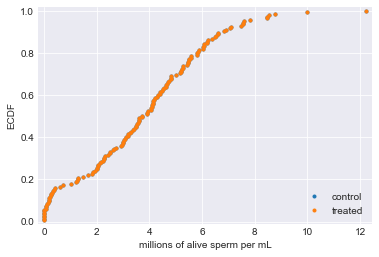

In [27]:
# Compute x,y values for ECDFs
x_control, y_control = ecdf(control)
x_treated, y_treated = ecdf(treated)

# Plot the ECDFs
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_treated, y_treated, marker='.', linestyle='none')

# Set the margins
plt.margins(0.02)

# Add a legend
plt.legend(('control', 'treated'), loc='lower right')

# Label axes and show plot
plt.xlabel('millions of alive sperm per mL')
plt.ylabel('ECDF')
plt.show()


### Nice plot! The ECDFs show a pretty clear difference between the treatment and control; treated bees have fewer alive sperm. Let's now do a hypothesis test in the next exercise.

### Bootstrap hypothesis test on bee sperm counts
Now, you will test the following hypothesis: On average, male bees treated with neonicotinoid insecticide have the same number of active sperm per milliliter of semen than do untreated male bees. You will use the difference of means as your test statistic.

For your reference, the call signature for the draw_bs_reps() function you wrote in chapter 2 is draw_bs_reps(data, func, size=1).

In [29]:
# Compute the difference in mean sperm count: diff_means
diff_means = np.mean(control) -np.mean(treated)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((control,treated)))

# Generate shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count

# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted,
                       np.mean, size=10000)
bs_reps_treated = draw_bs_reps(treated_shifted,
                       np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(control) - np.mean(treated)) \
            / len(bs_replicates)
print('p-value =', p)


p-value = 0.4951


#### Nice work! The p-value is small, most likely less than 0.0001, since you never saw a bootstrap replicated with a difference of means at least as extreme as what was observed. In fact, when I did the calculation with 10 million replicates, I got a p-value of 2e-05.

You have finished the chapter "Hypothesis test examples"!

Please give a rating:

## EDA of beak depths of Darwin's finches
For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

The data are stored in a pandas DataFrame called df with columns 'year' and 'beak_depth'. The units of beak depth are millimeters (mm).

In [31]:

df = pd.read_csv(path+"scandens_beak_depth_heredity.csv")
df.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In [ ]:
# Create bee swarm plot
_ = ____

# Label the axes
_ = plt.____('year')
_ = plt.____('beak depth (mm)')

# Show the plot
____